## Jupyter notebook for plotting clusters of CHi-C data
This notebook is the code for plotting clusters of the time course CHi-C used in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre. 

Author : *Jing Yang*  <br />
Date: 24-10-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### load required package

In [1]:
library(ggplot2)

### load normalized CHi-C data

In [2]:
chic_data_original <- read.table("https://personalpages.manchester.ac.uk/staff/jing.yang/Data/CHiC/data/CHiC_normalizeddata.txt", header=TRUE)

In [3]:
head(chic_data_original)

baitID,baitchr,baitstart,baitend,otherEndID,otherEndchr,otherEndstart,otherEndend,chr,ENSG,T01,T02,T201,T202,T1H1,T1H2,T4H1,T4H2,T24H1,corr_rep
<int>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
99879,chr10,119077883,119083160,100000,chr10,119687482,119688430,chr10,ENSG00000107581,2.685175,2.281339,0.000000,0.000000,2.386324,3.380836,0.000000,2.261001,1.636451,0.6626112
102382,chr10,127986294,127989968,100003,chr10,119702248,119714492,chr10,ENSG00000132334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.065419,0.000000,2.174726,NA
75393,chr10,35177215,35181230,100007,chr10,119716413,119724542,chr10,ENSG00000095794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.930548,NA
99879,chr10,119077883,119083160,100007,chr10,119716413,119724542,chr10,ENSG00000107581,3.994297,2.620208,3.419915,3.040367,3.129573,2.513083,2.269831,3.253201,2.727703,-0.6543762
99879,chr10,119077883,119083160,100008,chr10,119724542,119727941,chr10,ENSG00000107581,2.343036,3.124755,2.710272,3.501349,3.532390,0.000000,2.448842,2.933226,2.565841,-0.9135395
99894,chr10,119171553,119183998,100009,chr10,119727941,119728597,chr10,ENSG00000165672,0.000000,0.000000,0.000000,1.615820,0.000000,3.011241,0.000000,0.000000,1.266637,NA


### removing those data with flat time course profile on one replicate 

In [4]:
chic_data <- chic_data_original[!is.na(chic_data_original$corr_rep),]

### look at cis-interactions only

In [5]:
chic_data_samechr <- chic_data[as.character(chic_data$baitchr)==as.character(chic_data$otherEndchr),]

### only consider interactions within 5MB of promoters

In [6]:
idx_5MB <- which(abs(0.5*(chic_data_samechr$baitstart + chic_data_samechr$baitend) - 0.5*(chic_data_samechr$otherEndstart + chic_data_samechr$otherEndend))<5000000)

In [7]:
chic_data_within5MB <- chic_data_samechr[idx_5MB,]

### get averaged data for each time point

In [8]:
chic_data_within5MB$T0 <- 0.5*(chic_data_within5MB$T01 + chic_data_within5MB$T02)
chic_data_within5MB$T20 <- 0.5*(chic_data_within5MB$T201 + chic_data_within5MB$T202)
chic_data_within5MB$T1H <- 0.5*(chic_data_within5MB$T1H1 + chic_data_within5MB$T1H2)
chic_data_within5MB$T4H <- 0.5*(chic_data_within5MB$T4H1 + chic_data_within5MB$T4H2)
chic_data_within5MB$T24H <- chic_data_within5MB$T24H1


### clustering CHi-C data

In [9]:
chic_data_normalized <- t(scale(t(chic_data_within5MB[,c('T0','T20','T1H','T4H','T24H')]),center=TRUE,scale=TRUE))


In [10]:
### start kmeans

set.seed(5)
CLUSTER_SIZE = 100
kmeans_cluster <- kmeans(chic_data_normalized,centers=CLUSTER_SIZE,iter.max = 100)
#cluster_freq <- count(kmeans_cluster$cluster)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]
M <- 24
clusters_picked <- cl$x[1:M]
clusters_frequency <- cl$freq[1:M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus_chic <- numeric(0)
for (ii in 1:M){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii])   
    data_forillus_chic <- c(data_forillus_chic,c(t(chic_data_normalized[idx,])))
}
time <- c(0,1,2,3,4)

data_forplot_chic <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus_chic, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(1:M,clusters_frequency*length(time)),
                           #group_replicate = rep(rep(c(1,2), each=length(time)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7437100)”


### plot the clustering results

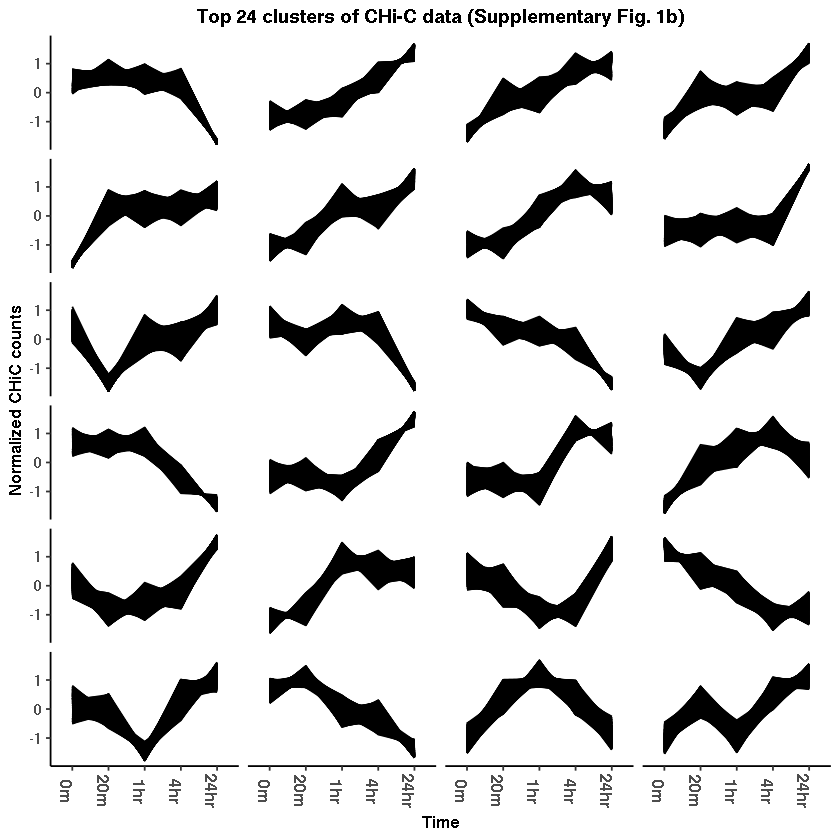

In [11]:
ggplot(data=data_forplot_chic, aes(x=factor(x),y=y,group=group_time)) + geom_line()+
   labs(title=" ", x ="Time", y = "Normalized CHiC counts") + ggtitle('Top 24 clusters of CHi-C data (Supplementary Fig. 1b)') +
   theme(panel.background=element_blank(),plot.title = element_text(hjust = 0.5, face='bold', size=12),
         axis.title=element_text(size=10,face="bold"), axis.text.x=element_text(size=10, face='bold', angle=-90,hjust=0.5), 
         axis.text.y=element_text(size=8, face='bold'),axis.line=element_line('black'),strip.text.x=element_blank(), strip.text.y=element_blank(), legend.position="none") +
     scale_x_discrete(breaks=c(0,1,2,3,4), labels=c('0m','20m','1hr','4hr','24hr')) +
facet_grid((group_cluster-1) %/%4 ~(group_cluster-1)%%4 )
